In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# 模型設定

In [2]:
class ThresholdNet(nn.Module):
    def __init__(self, input_features=4, hidden_dims=[128, 256, 128]):
        super(ThresholdNet, self).__init__()
        
        layers = []
        in_dim = input_features
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            in_dim = h_dim
            
        layers.append(nn.Linear(in_dim, 1))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        max_vals = torch.max(x, dim=1, keepdim=True)[0]
        min_vals = torch.min(x, dim=1, keepdim=True)[0]
        std_vals = torch.std(x, dim=1, keepdim=True)
        median_vals = torch.median(x, dim=1, keepdim=True)[0]
        
        features = torch.cat([max_vals, min_vals, std_vals, median_vals], dim=1)
        
        threshold = self.network(features)
        
        return threshold

# 資料生成器

In [3]:
def data_generator(data, labels, batch_size, shuffle=True):
    num_samples = data.shape[0]
    indices = torch.arange(num_samples)
    
    if shuffle:
        indices = torch.randperm(num_samples)
        
    for i in range(0, num_samples, batch_size):
        batch_indices = indices[i:i+batch_size]
        yield data[batch_indices], labels[batch_indices]

# 損失函數以及training process

In [4]:
def f1_loss(scores, labels, threshold, k=10.0, eps=1e-7):
    soft_predictions = torch.sigmoid(k * (scores - threshold))
    
    tp = (soft_predictions * labels).sum(dim=1)
    fp = (soft_predictions * (1 - labels)).sum(dim=1)
    fn = ((1 - soft_predictions) * labels).sum(dim=1)
    
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    
    f1 = 2 * (precision * recall) / (precision + recall + eps)
    
    return 1 - f1.mean()

In [5]:
def train_step(model, data_batch, label_batch, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    
    threshold = model(data_batch)
    
    loss = loss_fn(data_batch, label_batch, threshold)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

# 測試驗證

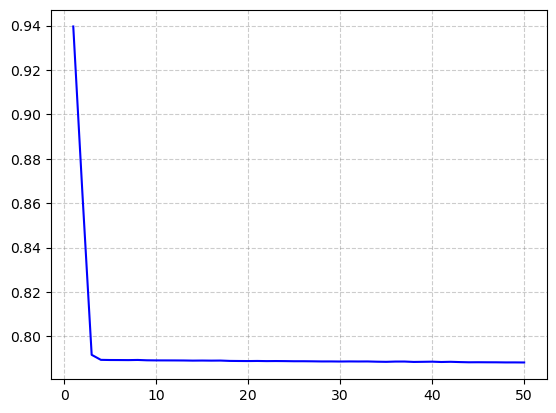

Training finished.

Test Anomaly Scores: [0.1  0.2  0.95 0.15 0.88]
Learned Threshold: 0.7903
Hard Predictions: [0 0 1 0 1]
True Labels:      [0 0 1 0 1]
TP: 2, FP: 0, FN: 0


In [6]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
EPOCHS = list()
LOSSES = list()
if __name__ == '__main__':
    n_samples = 2048
    n_series = 100
    
    anomaly_scores = torch.rand(n_samples, n_series) * 0.8
    labels = torch.zeros(n_samples, n_series, dtype=torch.float32)

    for i in range(n_samples):
        if torch.rand(1).item() > 0.5:
            num_anomalies = torch.randint(1, 10, (1,)).item()
            anomaly_indices = torch.randint(0, n_series, (num_anomalies,))
            anomaly_scores[i, anomaly_indices] = 0.8 + torch.rand(num_anomalies) * 0.2
            labels[i, anomaly_indices] = 1.0
            
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    anomaly_scores = anomaly_scores.to(device)
    labels = labels.to(device)
    
    model = ThresholdNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    epochs = 50
    batch_size = 64
    
    print("Starting training...")
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        batch_count = 0
        
        train_loader = data_generator(anomaly_scores, labels, batch_size, shuffle=True)
        
        for data_batch, label_batch in train_loader:
            loss = train_step(model, data_batch, label_batch, optimizer, f1_loss)
            epoch_loss += loss
            batch_count += 1
            
        
        avg_epoch_loss = epoch_loss / batch_count
        EPOCHS += [epoch]
        LOSSES += [avg_epoch_loss]
        clear_output()
        plt.figure()
        plt.plot(EPOCHS, LOSSES, color = "blue")
        plt.grid(color = "gray", linestyle = "--", alpha = .4)
        plt.show()
            
    print("Training finished.")
    
    model.eval()
    with torch.no_grad():
        test_scores = torch.tensor([[0.1, 0.2, 0.95, 0.15, 0.88]], dtype=torch.float32).to(device)
        test_labels = torch.tensor([[0.0, 0.0, 1.0, 0.0, 1.0]], dtype=torch.float32).to(device)
        
        learned_threshold = model(test_scores)
        print(f"\nTest Anomaly Scores: {test_scores.cpu().numpy().flatten()}")
        print(f"Learned Threshold: {learned_threshold.item():.4f}")
        
        predictions = (test_scores > learned_threshold).int()
        
        tp = ((predictions == 1) & (test_labels == 1)).sum().item()
        fp = ((predictions == 1) & (test_labels == 0)).sum().item()
        fn = ((predictions == 0) & (test_labels == 1)).sum().item()
        
        print(f"Hard Predictions: {predictions.cpu().numpy().flatten()}")
        print(f"True Labels:      {test_labels.cpu().numpy().flatten().astype(int)}")
        print(f"TP: {tp}, FP: {fp}, FN: {fn}")

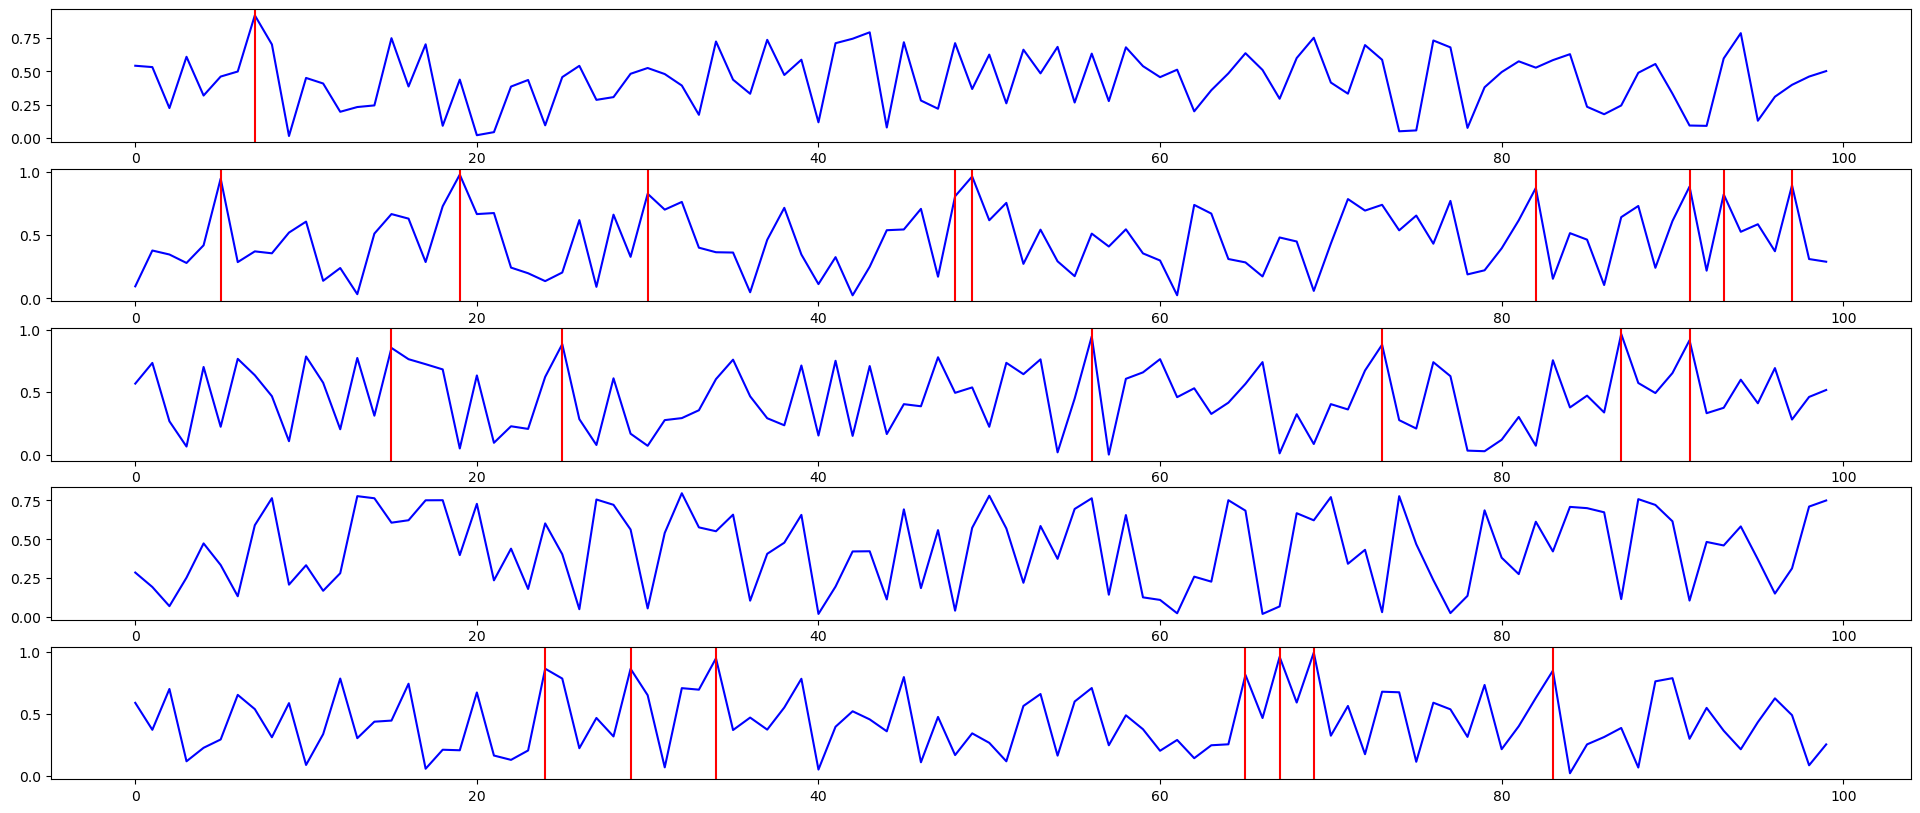

In [17]:
fig, ax = plt.subplots(5, 1, figsize = (24, 10))
cnt = 0
for d, l in zip(anomaly_scores, labels):
    ax[cnt].plot(d.cpu().detach(), color = "blue")
    ls = torch.where(l)[0].cpu()
    for _l in ls:
        ax[cnt].axvline(_l, color = "red")
    if cnt == 4:
        break
    cnt += 1
plt.show()